In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载源图与待拼接图像

In [2]:
path1 = 'images/left.jpg'
path2 = 'images/right.jpg'
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)

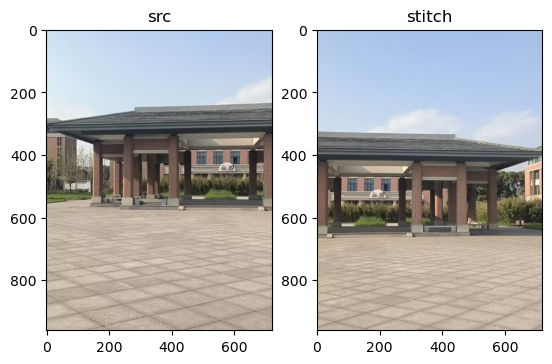

In [3]:
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title('src')
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title('stitch')
plt.show()

# 2. SIFT特征点检测

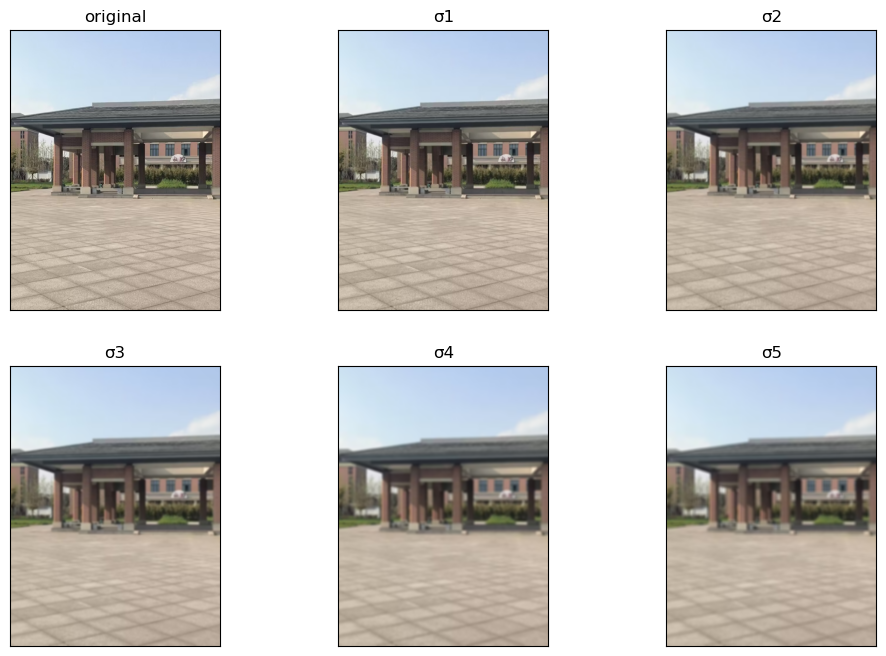

In [4]:
# 高斯金字塔示意图
f, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title("original")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

for i in range(1, 6):
    # 高斯模糊
    image_blur = cv2.GaussianBlur(img1, (15, 15), i)
    # 计算子图
    ax[int(i/3), i % 3].imshow(cv2.cvtColor(image_blur, cv2.COLOR_BGR2RGB))
    ax[int(i/3), i % 3].set_title("σ" + str(i))
    ax[int(i/3), i % 3].set_xticks([])
    ax[int(i/3), i % 3].set_yticks([])
plt.show()

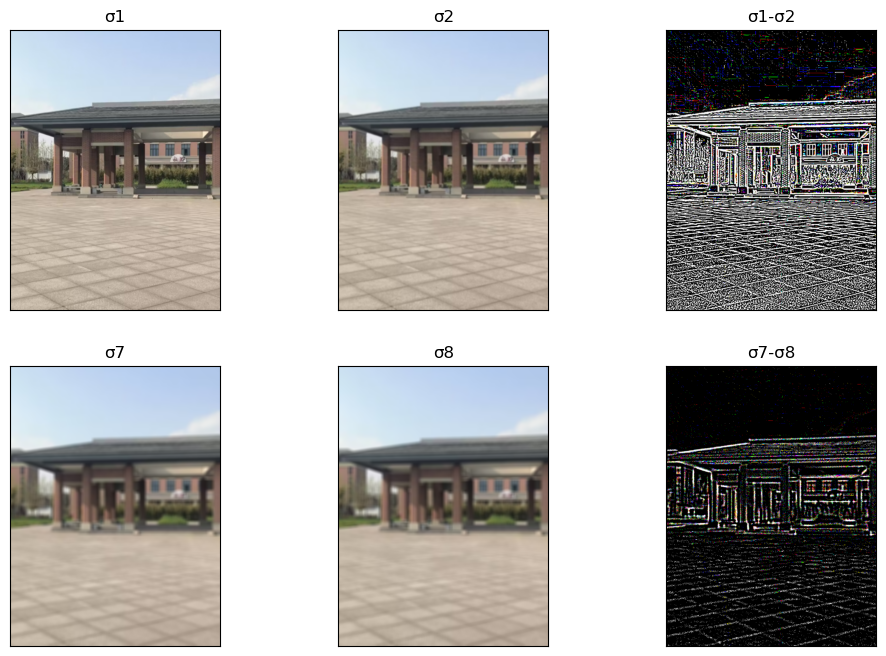

In [5]:
# 高斯差分金字塔示意图
image_blur1 = cv2.GaussianBlur(img1, (15, 15), 1) # 一次高斯模糊
image_blur2 = cv2.GaussianBlur(img1, (15, 15), 2) # 二次高斯模糊
DOG_12 = image_blur1 - image_blur2                # 高斯差分图1-2
image_blur7 = cv2.GaussianBlur(img1, (15, 15), 7) # 七次高斯模糊
image_blur8 = cv2.GaussianBlur(img1, (15, 15), 8) # 八高斯模糊
DOG_78 = image_blur7 - image_blur8                # 高斯差分图7-8
# 绘图
title = ['σ1', 'σ2', 'σ1-σ2', 'σ7', 'σ8', 'σ7-σ8']
images = [image_blur1, image_blur2, DOG_12, image_blur7, image_blur8, DOG_78]
f, ax = plt.subplots(2, 3, figsize=(12, 8))
for i in range(6):
    ax[int(i/3), i % 3].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax[int(i/3), i % 3].set_title(title[i]) 
    ax[int(i/3), i % 3].set_xticks([])
    ax[int(i/3), i % 3].set_yticks([])
plt.show()

In [6]:
# 检测sift特征点
sift = cv2.SIFT_create() # 使用cv2库中自带的sift特征检测器
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
print(des1.shape, des2.shape) # 128的特征向量
des1

(1646, 128) (1436, 128)


array([[123.,  33.,   0., ...,   8., 114.,  38.],
       [ 62.,   5.,   3., ...,   4.,   6.,  24.],
       [  1.,   0.,   0., ...,  31.,  37.,  59.],
       ...,
       [  0.,   2.,   6., ...,   0.,   0.,   2.],
       [  0.,   0.,   0., ...,  35.,   1.,   5.],
       [  6.,  10.,   5., ...,   0.,   0.,   0.]], dtype=float32)

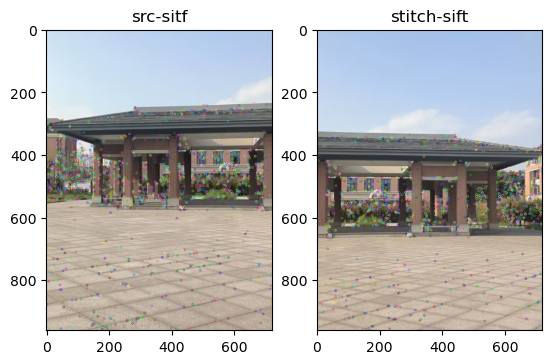

In [7]:
img_1 = cv2.drawKeypoints(img1, kp1, None)
img_2 = cv2.drawKeypoints(img2, kp2, None)
plt.subplot(121), plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)), plt.title('src-sitf')
plt.subplot(122), plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)), plt.title('stitch-sift')
plt.show()

# 3. SIFT特征点配准

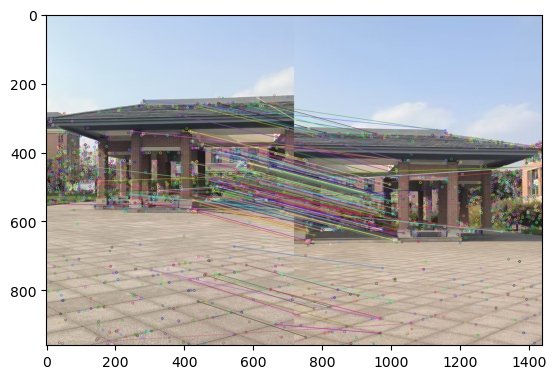

In [8]:
from scipy.spatial import KDTree
# 使用KDTree进行最近邻查询
tree = KDTree(des2)
dist, indices = tree.query(des1, k=2)
# 对特征点进行筛选，保留最近邻距离小于0.75倍次近邻距离的点
good_indices = np.where(dist[:, 0] < 0.75 * dist[:, 1])[0]
matches = []
for idx in good_indices:
    matches.append(cv2.DMatch(idx, indices[idx][0], dist[idx][0]))

# 绘制匹配结果
img_match = cv2.drawMatches(img1, kp1, img2, kp2, matches, None)
plt.imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))

In [9]:
# 使用RANSAC算法进行精确匹配
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
M #透视变换矩阵

array([[ 8.32967122e-01,  3.49863140e-02,  3.81599198e+02],
       [-1.33166513e-01,  1.00829504e+00, -7.72634255e+01],
       [-2.80048841e-04,  4.98799707e-05,  1.00000000e+00]])

# 4. 图像融合

In [10]:
# 计算融合后的图像尺寸
height_img1 = img1.shape[0]
width_img1 = img1.shape[1]
width_img2 = img2.shape[1]
height_panorama = height_img1
width_panorama = width_img1 + width_img2
print(height_img1, width_panorama)

960 1440


In [11]:
# 使左右两个图像之间的过渡更加平滑
def create_mask(img1, img2, version):
    """
    创建用于图像拼接的掩码，实现边缘渐变融合效果。
    Args:
        img1: 第一幅图像。
        img2: 第二幅图像。
        version: 当前图像是左图还是右图，取值为'left_image'或'right_image'。
    Returns:
        一个形状为`(height_panorama, width_panorama, 3)`的掩码数组，其中每个元素的值表示对应像素在拼接后的图像中的透明度。
    """
    # 获取输入图像的大小信息
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    
    # 创建大小为`(height_panorama, width_panorama)`的全0数组作为掩码
    mask = np.zeros((height_panorama, width_panorama))
    
    # 设置渐变区域的大小和位置
    smoothing_window_size = 20
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    
    # 如果当前图像是左图
    if version== 'left_image':
        mask[:, :barrier - offset] = 1  # 将`mask`的左半部分设为1
        # 右半部分使用线性渐变将值从1逐渐降低到0，使得左图的边缘逐渐融合到右图中
        mask[:, barrier - offset: barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_panorama, 1))
    # 如果当前图像是右图
    else:
        mask[:, barrier + offset:] = 1  # 将`mask`的右半部分设为1
        # 左半部分使用线性渐变将值从0逐渐增加到1，使得右图的边缘逐渐融合到左图中
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_panorama, 1))
    
    # 将掩码沿着通道方向复制3次，得到形状为`(height_panorama, width_panorama, 3)`的掩码
    return cv2.merge([mask, mask, mask])

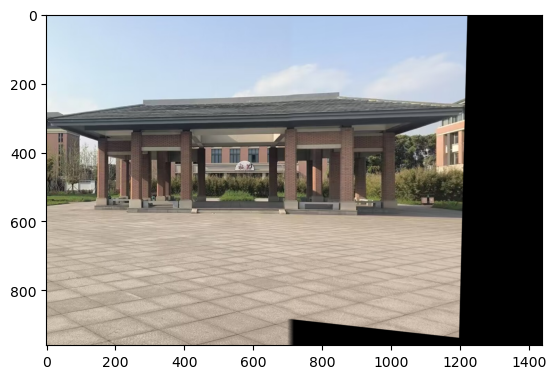

In [12]:
# 创建全零矩阵，大小为拼接后全景图像的尺寸，维度为3，RGB图像
panorama1 = np.zeros((height_panorama, width_panorama, 3))
# 创建掩码数组
mask1 = create_mask(img1, img2, version='left_image')
# 将左图img1复制到全景图像的左边，与左边界对齐
panorama1[0: img1.shape[0], 0: img1.shape[1], :] = img1
# 左图像素与掩码相乘，平滑像素
panorama1 *= mask1
# 创建右图img2的掩码矩阵
mask2 = create_mask(img1, img2, version='right_image')
# 使用透视变换矩阵M将右图img2进行透视变换，并将变换后的图像乘以掩膜矩阵mask2
panorama2 = cv2.warpPerspective(img2, M, (width_panorama, height_panorama)) * mask2
# 将左图img1与经过透视变换的右图img2融合
result = panorama1 + panorama2
result = result.astype('uint8')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

True

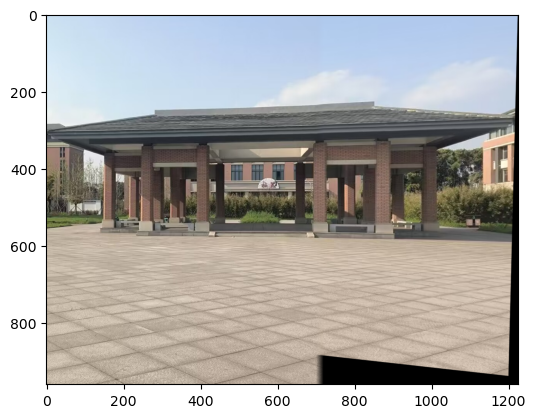

In [13]:
# 裁剪边缘
rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]
plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
cv2.imwrite('panorama.jpg', final_result)